In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [3]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # PIL 형태로 이미지를 얻음
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(cifar10_val)

10000

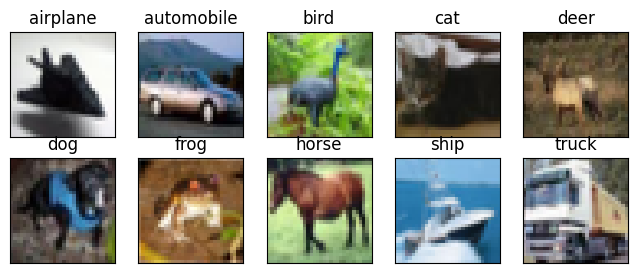

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [4]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

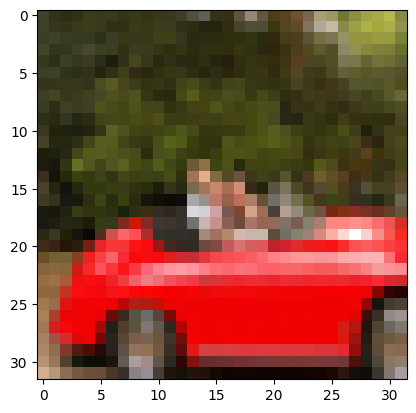

In [5]:
plt.imshow(img)
plt.show()

## ToTensor 변환

> 넘파이 배열과 PIL 이미지를 텐서로 바꾸는 역할을 한다.

In [6]:
from torchvision import transforms

to_tensor = transforms.ToTensor() # 토치비전의 ToTensor를 통해 텐서화
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

- 이미지가 3x32x32 텐서로 바뀌었다
- RGB 세 개의 채널을 가지는 32x32 이미지가 됐다.
- label값은 변동 없이 정수값을 그대로 가짐

> 처음부터 변환 자체를 datasets.CIFAR10의 인자로 전달하는 것도 가능

In [7]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor()) # 텐서화 내장

In [8]:
img_t, _ = tensor_cifar10[99]
type(img_t),img_t.shape,img_t.dtype

(torch.Tensor, torch.Size([3, 32, 32]), torch.float32)

- 원본 PIL 이미지 값은 0에서 255(채널당 8비트) 범위
- ToTensor 변환으로 데이터가 채널당 32비트 부동소수점 형태 0.0~1.0 사이로 범위가 줄어듬

In [9]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

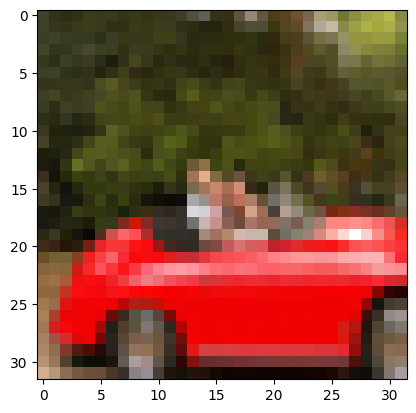

In [10]:
# 이미지 동일한지 확인
plt.imshow(img_t.permute(1, 2, 0))  # C X H X W를 H X W X C로 바꿔준다(4.1.3 레이아웃 변경하기)
plt.show()

## 데이터정규화

> 모든 채널이 평균값 0과 단위 표준편차를 가지도록 데이터셋의 각 채널의 평균과 표준편차를 계산: $ v_n[c] =  (v[c] - mean[c]) / sedev[c] $

- [-1,-2]에서 선형인 활성 함수를 택하고 데이터를 같은 범위에서 평균을 가지게 한다면 뉴런은 0이 아닌 기울기를 가지게 되므로 빨리 학습할 수 있다.
- 각 채널을 정규화해 동일한 분산을 가지게 한다면 채널 정보가 동일한 학습률로 경사 하강을 통해 섞이고 업데이트되는 것도 보장할 수 있다.

In [11]:
# 추가 차원을 만들어 데이터셋이 반환하는 모든 텐서 쌓기
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [12]:
# 평균과 표준편차 계산
imgs.view(3, -1).mean(dim=1),imgs.view(3, -1).std(dim=1)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [13]:
# Normalize 변환 초기화
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [14]:
# ToTensor 변환에 이어 붙이기
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(), # 텐서화
        transforms.Normalize((0.4914, 0.4822, 0.4465), # 정규화
                             (0.2470, 0.2435, 0.2616))
    ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


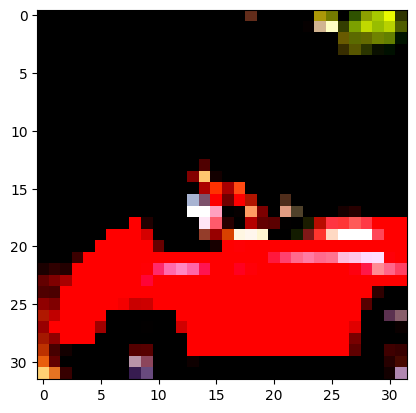

In [15]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

- RGB 값을 0과 1 사이 범위로 만들었고 채널값의 범위도 다 바꿔버렸다
- 값은 바뀌었으나 데이터는 여전히 존재(검정색은 matplotlib 출력일뿐)

In [16]:
img_t

tensor([[[-1.0051, -1.1956,  ...,  0.9160,  0.1856],
         [-0.9892, -1.1163,  ...,  0.7255,  0.3127],
         ...,
         [ 0.9160,  0.3920,  ...,  0.1539,  0.2809],
         [ 1.3288,  0.9001,  ...,  0.0745,  0.6937]],

        [[-0.9496, -1.1750,  ...,  0.9830,  0.2100],
         [-0.9335, -1.1267,  ...,  0.8220,  0.3710],
         ...,
         [ 0.3710, -0.0799,  ..., -0.0799,  0.0328],
         [ 0.8220,  0.4516,  ..., -0.0638,  0.5321]],

        [[-1.0472, -1.3170,  ..., -0.5675, -0.6275],
         [-1.1521, -1.3170,  ..., -0.5825, -0.5525],
         ...,
         [ 0.0471, -0.2827,  ..., -0.2377, -0.0578],
         [ 0.4519,  0.1371,  ..., -0.0428,  0.6917]]])

# 새와 비행기를 구별하기

## 1. 비행기와 새만 들어간 데이터셋 구축

In [62]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [63]:
label_map = {0: 0, 2: 1} # 기존 레이블 0(비행기)를 0으로,2(새)를 1로 
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

## 2. 완전 연결 모델 만들기

- 이미지를 1차원 벡터로 간주하여 신경말 만들기
- 샘플의 피처는 32X32X3=3072개

> 초기에서는 구조적인 관계를 모르기 때문에 관계에 집중하지 않음!
ex) 176 208 피처

## 출력

- 신경망이 단일한 스칼라값(n_out=1)을 출력하게 만듬
- 출력값은 요소는 0과 1사이
- 모든 출력 요소의 합은 1.0
- 이러한 제한을 극복하고 미분 가능하게 해주는 방법:  *소프트맥스*

## 출력을 확률로 표현하기

`-` 소프트맥스
- 벡터값을 받아 동일한 차원의 다른 벡터를 만드는데, 값이 확률로 표현되어야 하는 제약을 만족한다.

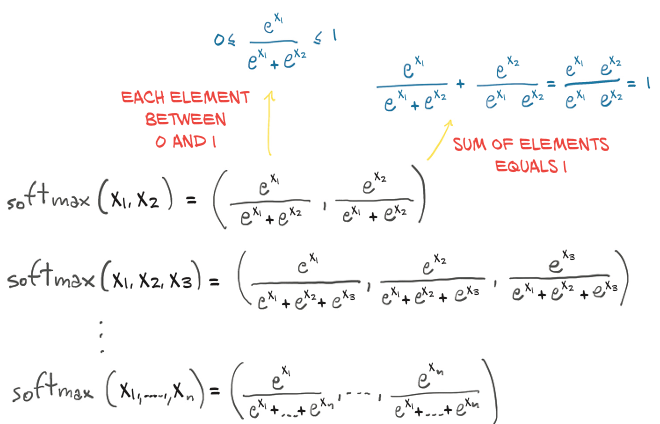

In [65]:
# 소프트맥스 코드
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [66]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x),softmax(x).sum()

(tensor([0.0900, 0.2447, 0.6652]), tensor(1.))

In [67]:
# 모델 설정 활성함수 tanh
import torch.nn as nn

model = nn.Sequential(
            nn.Linear(3072,512),   # 임의로 512개의 은닉된 피처 선택
            nn.Tanh(),
            nn.Linear(512,2),
            nn.Softmax(dim=1)) # 확률값으로 표현

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


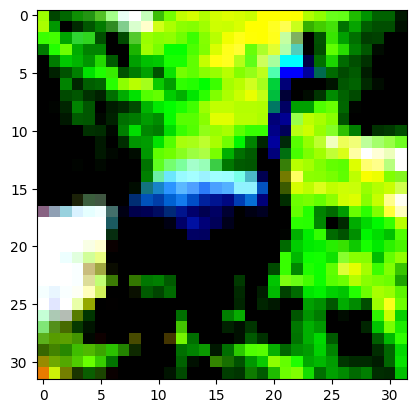

In [68]:
# 새
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [69]:
img.view(-1) #view는 1차원벡터로 만들어주는 코드
len(img.view(-1))

3072

In [70]:
img_batch = img.view(-1).unsqueeze(0) # 1차원벡터로 만들어주는 코드
len(img_batch)

1

In [71]:
img_batch = img.view(-1).unsqueeze(0) # 1차원벡터로 만들어주는 코드

out = model(img_batch)
out

tensor([[0.4517, 0.5483]], grad_fn=<SoftmaxBackward0>)

In [72]:
# 출력값이 의미하는 인덱스 출력 (새 또는 비행기)
_, index = torch.max(out, dim=1)
index

tensor([1])

## 분류를 위한 손실값

> 정확하게 0.0이나 1.0이 아닌 모든 경우를 애써가며 벌점을 주는 대신 분류가 어긋나는 경우에 벌점을 주고 싶다.

- 정답 클래스에 대한 확률 수치: 가능도
- 가능도가 낮을 때 손실 함수 증가(다른 클래스의 확률이 높은 경우)
- 반대로 가능도가 높을 때는 손실 함수 낮아야 함(1.0, 0.0 에 집착 금지)

`-` NLL(Negative Log Likelihood) : 위와 같은 식으로 동작하는 손실 함수

$$ NLL = -sum(log(out_i[c_i])) $$

- c_i : 샘플 i에 대한 정답 클래스
- 낮은 가능도의 경우 NLL은 무한으로 늘어나는 반면, 확률이 0.5보다 커지는 경우 NLL은 완만하게 감소

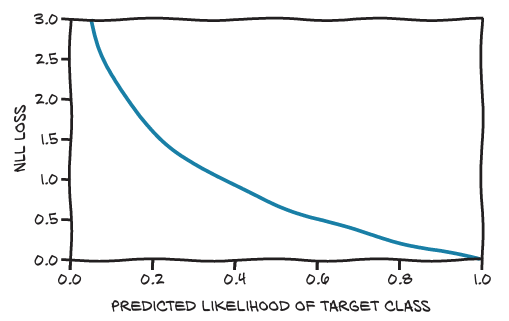

- nn.NLLLoss 클래스는 기대와 달리, 확률 대신 로그 확률의 텐서를 받는다.
- 그리고 데이터 배치에 대한 모델의 NLL을 계산한다
- 

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

In [29]:
loss = nn.NLLLoss()

In [30]:
img, label = cifar2[1]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(-0.4324, grad_fn=<NllLossBackward0>)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 3

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 4.627971
Epoch: 1, Loss: 4.726174
Epoch: 2, Loss: 5.137678


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.340193
Epoch: 1, Loss: 0.310702
Epoch: 2, Loss: 0.482252
Epoch: 3, Loss: 0.547645
Epoch: 4, Loss: 0.388780
Epoch: 5, Loss: 0.447440
Epoch: 6, Loss: 0.458342
Epoch: 7, Loss: 0.526321
Epoch: 8, Loss: 0.359252
Epoch: 9, Loss: 0.436477
Epoch: 10, Loss: 0.465674
Epoch: 11, Loss: 0.462838
Epoch: 12, Loss: 0.168525
Epoch: 13, Loss: 0.195295
Epoch: 14, Loss: 0.396799
Epoch: 15, Loss: 0.245649
Epoch: 16, Loss: 0.569880
Epoch: 17, Loss: 0.304690
Epoch: 18, Loss: 0.103078
Epoch: 19, Loss: 0.550747
Epoch: 20, Loss: 0.218130
Epoch: 21, Loss: 0.112153
Epoch: 22, Loss: 0.180714
Epoch: 23, Loss: 0.281837
Epoch: 24, Loss: 0.392541
Epoch: 25, Loss: 0.116403
Epoch: 26, Loss: 0.173645
Epoch: 27, Loss: 0.149094
Epoch: 28, Loss: 0.228210
Epoch: 29, Loss: 0.231650
Epoch: 30, Loss: 0.213211
Epoch: 31, Loss: 0.284795
Epoch: 32, Loss: 0.134407
Epoch: 33, Loss: 0.511469
Epoch: 34, Loss: 0.210802
Epoch: 35, Loss: 0.180235
Epoch: 36, Loss: 0.237430
Epoch: 37, Loss: 0.129498
Epoch: 38, Loss: 0.176

In [49]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.998800


In [47]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.806500


In [54]:
# 모델에 계층을 추가하면 모델의 깊이나 용량이 늘어나게 된다
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

In [ ]:
- nn.LogSoftmax와 nn.NLLLoss의 조합은 nn.CrossEntropyLoss() 와 동일하다
- 모델의 출력을 확률로 해석 가능하지 못하다는 단점이 있다.